# Egypt serving malware

In [1]:
import pandas as pd
import numpy as np
import functools
from matplotlib import pylab as plt

In [2]:
%matplotlib inline

## Data massage

In [3]:
!tshark -2 -r mads-141.0.174.38.pcap -Tfields \
    -eframe.time_epoch \
    -eip.id -e ip.ttl -e ip.dst \
    -etcp.srcport -etcp.dstport -etcp.len -etcp.stream -etcp.seq -etcp.ack -etcp.flags.str -etcp.window_size \
    -etcp.options.timestamp.tsval -etcp.options.timestamp.tsecr \
    -etcp.analysis.initial_rtt -etcp.analysis.ack_rtt \
    -ehttp.host -ehttp.response.code -ehttp.user_agent -ehttp.location \
    > mads-141.0.174.38.txt

In [4]:
data = pd.read_csv('./mads-141.0.174.38.txt', delimiter='\t',
            names=
                ('time_epoch id ttl dst srcport dstport len stream seq ack flags window_size '
                'tsval tsecr initial_rtt ack_rtt host code user_agent location').split())

In [5]:
data['intid'] = data.id.apply(functools.partial(int, base=16))
data.time_epoch -= data.time_epoch.min()

In [6]:
data.sample(1).T

,2072
time_epoch,2351.17
id,0x00006818
ttl,64
dst,141.0.174.38
srcport,37546
dstport,80
len,0
stream,211
seq,126
ack,414


In [7]:
len(data.stream.unique())

494

In [8]:
data.host.value_counts()

xnxx.com        493
www.xnxx.com      1
Name: host, dtype: int64

`www.xnxx.com` stream is not really interesting as it's just a single webpage that occasionally hit the dataset.

In [9]:
data.location.value_counts()

http://www.xnxx.com/                 477
http://marketing-sv.com/mads.html      6
Name: location, dtype: int64

There are three different sorts of streams in the dataset. 
*Good* streams get correct redirect, *bad* streams get injection, *ugly* streams get no redirect at all.

In [10]:
s_good = set(data[data.location == 'http://www.xnxx.com/'].stream)
s_bad = set(data[data.location == 'http://marketing-sv.com/mads.html'].stream)
s_ugly = set(data[data.host == 'xnxx.com'].stream) - set(data[~data.location.isnull()].stream)
print 'Bad:', sorted(s_bad)
print 'Ugly:', sorted(s_ugly)

Bad: [117, 268, 274, 278, 287, 294]
Ugly: [110, 116, 121, 269, 279, 281, 282, 291, 292, 296]


## RTT to HTTP response for *good* & *bad* streams

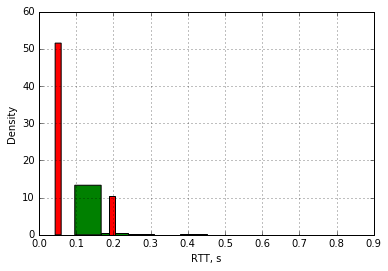

In [11]:
data[(data.stream.isin(s_good)) & (~data.code.isnull())].ack_rtt.hist(color='green', normed=True)
data[(data.stream.isin(s_bad)) & (~data.code.isnull())].ack_rtt.hist(color='red', normed=True)
plt.xlabel('RTT, s'); plt.ylabel('Density');

There are not so much streams outside of 250ms range, so let's look at high-res histograms at that range.

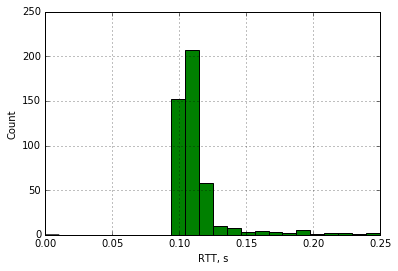

In [12]:
data[(data.stream.isin(s_good)) & (~data.code.isnull())].ack_rtt.hist(bins=np.linspace(0, 0.25, 25), color='green')
plt.xlabel('RTT, s'); plt.ylabel('Count');

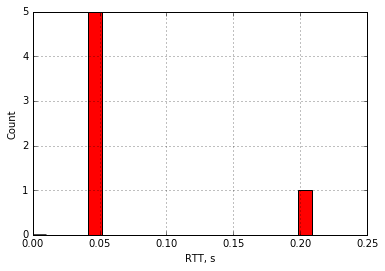

In [13]:
data[(data.stream.isin(s_bad)) & (~data.code.isnull())].ack_rtt.hist(bins=np.linspace(0, 0.25, 25), color='red')
plt.xlabel('RTT, s'); plt.ylabel('Count');

We have only six samples of injected redirects, but five of these samples have significantly lower RTT than the usual RTT of http response. The ~45ms RTT corresponds well to the latency of last-mile ADSL link that was used during this analysis, so it is close to latency to get a packet from ISP's network.

## Let the good streams roll

In [14]:
d_good = data[data.stream.isin(s_good) & (data.srcport == 80)]
d_good[d_good.tsval.isnull()].shape

(0, 21)

So, good data from server **always** has TCP timestamp, there are no rows in the slice.

In [15]:
d_good.ttl.value_counts()

54    1447
Name: ttl, dtype: int64

So, good data from server **always** has `TTL=54`.

Let's look at [IP fragment ID](https://en.wikipedia.org/wiki/IPv4#Identification) field:

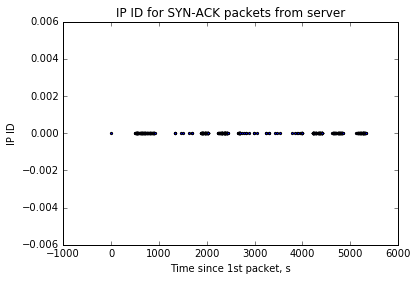

In [16]:
dsa = d_good[d_good.flags == '*******A**S*']
plt.scatter(dsa.time_epoch, dsa.intid, marker='.')
plt.xlabel('Time since 1st packet, s'); plt.ylabel('IP ID')
plt.title('IP ID for SYN-ACK packets from server');

Min/Max IP ID observed for non-SYN-ACK packets: 79 65340


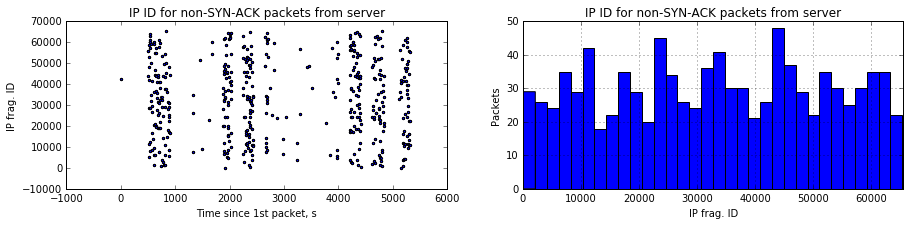

In [17]:
dsa = d_good[d_good.flags != '*******A**S*']

fig = plt.figure(); fig.set_figwidth(15); fig.set_figheight(3)

ax = fig.add_subplot(1, 2, 1)
ax.scatter(dsa.time_epoch, dsa.intid, marker='.')
ax.set_xlabel('Time since 1st packet, s'); ax.set_ylabel('IP frag. ID')
ax.set_title('IP ID for non-SYN-ACK packets from server');

ax = fig.add_subplot(1, 2, 2)
dsa.intid.hist(bins=32, ax=ax)
ax.set_xlim(0, 2**16)
ax.set_xlabel('IP frag. ID'); ax.set_ylabel('Packets')
ax.set_title('IP ID for non-SYN-ACK packets from server');

print 'Min/Max IP ID observed for non-SYN-ACK packets:', dsa.intid.min(), dsa.intid.max()

Good server replies with `IP-ID=0` in `SYN-ACK` and almost never has `IP-ID=0` in other packets, IP-ID is rather random for other packets.

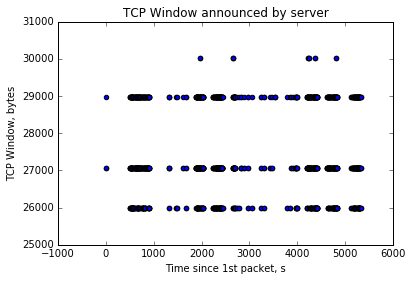

In [18]:
plt.scatter(d_good.time_epoch, d_good.window_size)
plt.xlabel('Time since 1st packet, s'); plt.ylabel('TCP Window, bytes');
plt.title('TCP Window announced by server');

Good server has window size in 25k…31k range (scaling is applied).

## Bisect bad streams one-by-one

In [19]:
print sorted(s_bad)

[117, 268, 274, 278, 287, 294]


In [20]:
d_bad = data[data.stream.isin(s_bad) & (data.srcport == 80)]
d_bad['time_epoch stream id ttl len seq ack flags window_size tsval ack_rtt'.split()].sort_values(by=['stream', 'time_epoch'])

,time_epoch,stream,id,ttl,len,seq,ack,flags,window_size,tsval,ack_rtt
1188,1589.229151,117,0x00000000,54,0,0,1,*******A**S*,28960,3.100932e+09,0.103577
1191,1589.274511,117,0x00003412,59,99,1,213,*******A***F,513920,NaN,0.045109
1193,1589.374932,117,0x00003412,59,0,101,214,*******A****,513920,NaN,0.099951
1226,1709.330761,117,0x00003f9c,54,212,1,1,*******A***F,26000,3.101052e+09,NaN
2583,2705.941551,268,0x00000000,54,0,0,1,*******A**S*,28960,3.102049e+09,0.110307
2586,2705.987294,268,0x00003412,59,99,1,248,*******A***F,513920,NaN,0.045296
2588,2706.086246,268,0x00003412,59,0,101,249,*******A****,513920,NaN,0.097518
2655,2826.044916,268,0x0000ee27,54,212,1,1,*******A***F,26000,3.102169e+09,NaN
2649,2816.015924,274,0x00000000,54,0,0,1,*******A**S*,28960,3.102159e+09,0.103654
2652,2816.059978,274,0x00003412,59,99,1,135,*******A***F,513920,NaN,0.043669


So, all packets that look-like-injected have:
- IP-ID=0x3412
- IP TTL=59
- no TCP options

The server also sends `408 Request timeout` in 120 seconds. It means, that the server has not seen the request at all, so the injector act as an in-band device.

Also ACK that is confirming FIN-ACK is looks like injected according to IP ID and TTL, but it has **weird RTT** (~98ms, but not ~44ms).

### Stream 287

That's injected stream that has ~200ms latency. On the other hand, *genuine* SYN-ACK from the server also has larger-than-usual RTT, so it's probably just a temporary Bufferbloat lag.

In [21]:
d_bad[d_bad.stream == 287]['time_epoch stream id ttl len seq ack flags window_size tsval ack_rtt'.split()]

,time_epoch,stream,id,ttl,len,seq,ack,flags,window_size,tsval,ack_rtt
2810,3368.165062,287,0x00000000,54,0,0,1,*******A**S*,28960,3.102711e+09,0.267423
2813,3368.370601,287,0x00003412,59,99,1,199,*******A***F,513920,NaN,0.205282
2815,3368.389520,287,0x00003412,59,0,101,200,*******A****,513920,NaN,0.018347
2834,3488.267293,287,0x0000004f,54,212,1,1,*******A***F,26000,3.102831e+09,NaN


The interesting thing about this stream is that ACK confirming FIN-ACK has 18ms ACK_RTT, so it actually means that the packet was likely sent **BEFORE** seeing the FIN from the client as the last-mile RTT is ~38ms according to `mtr` measurements.

If the statement is actually true, then another question arises: why is ACK-confirming-FIN-ACK usually ~98ms delayed? Is it triggered by some packet from original server? Is it sort of latency camouflage? No further research was done yet to clarify these questions.

## Ugly streams

In [22]:
d_ugly = data[data.stream.isin(s_ugly) & (data.srcport == 80)]
d_ugly.groupby(by='stream tsecr'.split()).time_epoch.agg(['count'])

count
stream tsecr           
110    614915.0       1
       614943.0      10
116    747274.0       1
       747297.0       7
121    786823.0       1
       786847.0      10
269    1034918.0      1
       1034942.0     10
279    1110335.0      1
       1110359.0      3
281    1143649.0      1
       1143672.0     10
282    1151512.0      1
       1151536.0     10
291    1239517.0      1
       1239540.0      9
292    1279490.0      1
       1279514.0      9
296    1318977.0      1
       1319001.0      9

It means, that the remote server has seen `SYN` packet and the first `ACK` after the `SYN`, but the server has never seen the request itself. It suggests that the *ugly* streams are just a sort of *bad* streams those got no redirection packet for some reason.

## Reunion of the bad and the ugly

It's interesting that only mobile User-agents were redirected to the `…/mads.html`. Our test sent ~33% of requests using mobile User-Agent and 67% of requests using desktop User-Agent.

In [23]:
d_goo = data[data.stream.isin(s_bad | s_ugly)]
d_goo.user_agent.value_counts()

Mozilla/5.0 (Linux; U; Android 4.0.3; de-de; Galaxy S II Build/GRJ22) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30                                                 2
Mozilla/5.0 (PlayBook; U; RIM Tablet OS 2.1.0; en-US) AppleWebKit/536.2+ (KHTML like Gecko) Version/7.2.1.0 Safari/536.2+                                                                     1
Mozilla/5.0 (Linux; U; Android 1.5; en-us; SPH-M900 Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1                                                1
Mozilla/5.0 (Linux; U; Android 2.2; en-us; Sprint APA9292KT Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1                                                1
Mozilla/5.0 (Linux; U; Android 2.2; en-ca; GT-P1000M Build/FROYO) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1                                                       1
Mozilla/5.0 (Symbian/3; Series60/5.2 Nok

It explains why OONI dataset sees no redirection. We've seen redirections only for mobile `User-Agent` so probably the DPI targets mobile users.

In [24]:
print 'Redirection happens in %.1f%% cases' % (100.*len(s_bad|s_ugly) / len(set(data.stream)))

print 'Redirection happens in %.1f%% of mobile cases' % (100.*len(s_bad|s_ugly) / 
         len(set(data[data.user_agent.str.match('.*(?:Android|RIM|Symbian|Series60|iPhone|BlackBerry|MIDP)', as_indexer=True) == True].stream)))

Redirection happens in 3.2% cases
Redirection happens in 9.9% of mobile cases
